For simplicity, we assume that the redshift distribution can be well parametrized by the function (Eq 3.8 from LSST Science Book)

$$ p(z) = \frac{1}{2z_0}\left( \frac{z}{z_0} \right)^2 \exp(-z/z_0) $$,

where the parameter $z_0$ is assumed to be linear relationship with the limiting magnitude $i_{lim}$: $$z_0 = a  i_{lim} + b.$$

This functional form offers a convenient mean redshift $ \langle z \rangle = 3z_0$. The peak is located at $2z_0$.

The DESC SRD gives two data points to constrain the coefficients $a$ and $b$. For $i_{lim} = 24.1$, $\langle z \rangle = 0.92$ and for $i_{lim} = 25.3$, $\langle z \rangle = 1.08$. 

In [1]:
ilim = [24.1, 25.3]
meanz = [0.92, 1.08]

In [2]:
%%capture 
from scipy.optimize import curve_fit
((a, b), _) = curve_fit(lambda x,a,b:3*a*x+3*b, ilim, meanz)

These values are different from, but close to the values (0.0417, -0.744) specified in the LSST Science Book calibrated based on DEEP2 data.

In [3]:
print(a, b)

0.044444444444444446 -0.7644444444444444


In [4]:
def p(z, ilim, a=a, b=b):
    z0 = a*ilim + b
    return 0.5/z0*(z/z0)*(z/z0)*np.exp(-z/z0)

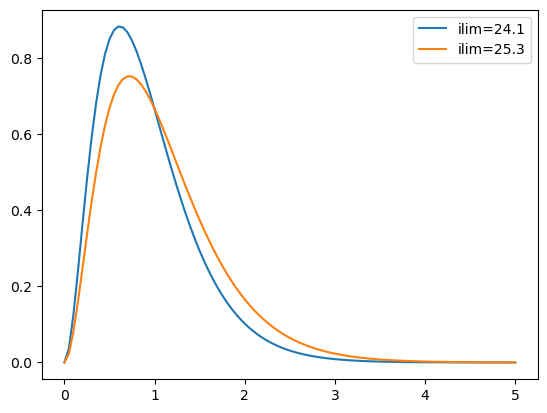

In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
Z = np.linspace(0, 5, 101)
for ilim in [24.1, 25.3]:
    plt.plot(Z, p(Z, ilim), '-', label=f"{ilim=}")
_ = plt.legend(loc="best")

We define tomographic bins to be percentiles of the $p(z)$ distribution. For the functional form of our choice, the tomographic bin edges are given by

$$\gamma(3, z(k)/z_0) = k/n \;\;\;\; (k=0,...,n),$$

where $n$ is the total number of tomographic bins and $\gamma(a, x)$ denotes the incomplete Gamma function of order $a$. Note that for any $n \ge 1$, $z(0) = 0$ and $z(n) = \infty$.

In [6]:
import numpy as np
import scipy.special as sc

def percentile_bin_boundaries(*, ilim, num_bins=5, a=a, b=b, **kwargs):
    """Return the tomographic bin boundaries.
    
    The number of returned values will be one more than ``num_bins``.
    The first entry should always be 0 and the last entry should be np.inf.
    """
    z0 = a*ilim + b
    return sc.gammaincinv(3, np.arange(0, 1 + 0.1/num_bins, 1./num_bins))*z0

def fixed_bin_boundaries(*, num_bins=5, zmin=0, zmax=2, a=a, b=b, **kwargs):
    return np.linspace(zmin, zmax, num_bins+1)

Select one of the above binning scheme

In [7]:
tomographic_bin_boundaries = fixed_bin_boundaries

For 5 tomographic bins, the edges (for $z$) are given by

In [8]:
tomographic_bin_boundaries(ilim=24.1, num_bins=5).tolist()

[0.0, 0.4, 0.8, 1.2000000000000002, 1.6, 2.0]

and for 10 tomographic bins, the edges (for $z$) are given by

In [9]:
tomographic_bin_boundaries(ilim=25.2, num_bins=10).tolist()

[0.0,
 0.2,
 0.4,
 0.6000000000000001,
 0.8,
 1.0,
 1.2000000000000002,
 1.4000000000000001,
 1.6,
 1.8,
 2.0]

The tomographic bin edges, if defined in terms are percentiles, are also linear in $z_0$ and hence in $i_{lim}$.

Text(0.5, 1.0, 'Percentile tomographic bins')

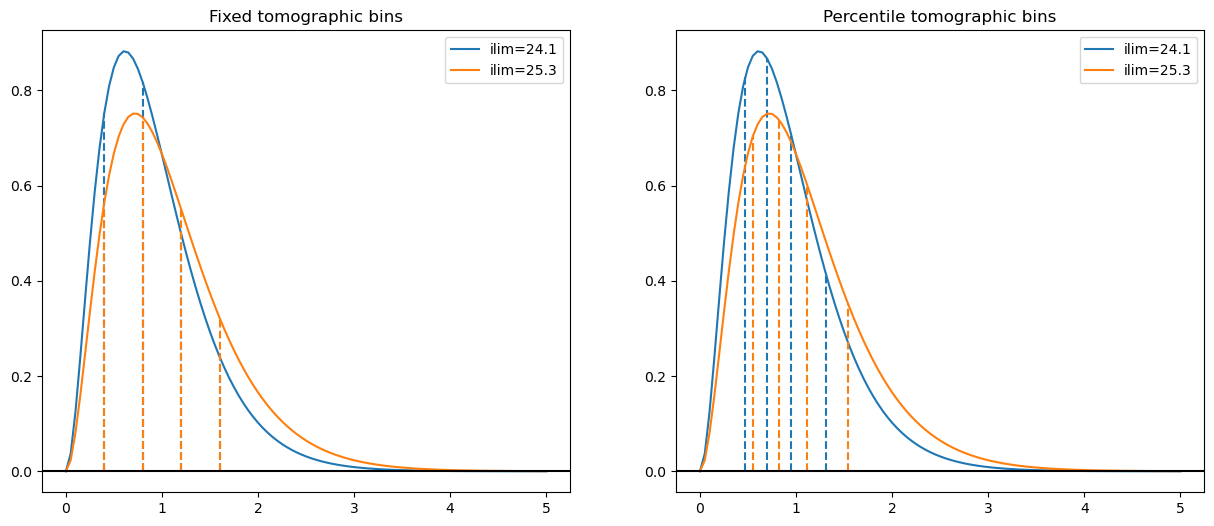

In [10]:
Z = np.linspace(0, 5, 101)
fig, ax = plt.subplots(1, 2)
fig.set_size_inches([15, 6])

for i, ilim in enumerate([24.1, 25.3]):
    ax[0].plot(Z, p(Z, ilim), '-', label=f"{ilim=}")
    X = fixed_bin_boundaries(ilim=ilim, num_bins=5)[:-1]
    ax[0].vlines(X, ymin=0, ymax=p(X, ilim), ls="--", color=f"C{i}")
ax[0].axhline(0.0, ls="-", color="k")
_ = ax[0].legend(loc="best")
ax[0].set_title("Fixed tomographic bins")

for i, ilim in enumerate([24.1, 25.3]):
    ax[1].plot(Z, p(Z, ilim), '-', label=f"{ilim=}")
    X = percentile_bin_boundaries(ilim=ilim, num_bins=5)[:-1]
    ax[1].vlines(X, ymin=0, ymax=p(X, ilim), ls="--", color=f"C{i}")
ax[1].axhline(0.0, ls="-", color="k")
_ = ax[1].legend(loc="best")
ax[1].set_title("Percentile tomographic bins")

The mean redshift within the $k^\text{th}$ tomographic bin is given by

$$ \langle z \rangle_k = 3z_0\frac{\left[ \gamma(4, z(k)/z_0) - \gamma(4, z(k-1)/z_0) \right]}{\left[ \gamma(3, z(k)/z_0) - \gamma(3, z(k-1)/z_0) \right]}$$

For the case where the tomographic binning is designed to have equal number in each bin, it simplifies to

$$ \langle z \rangle_k = 3z_0n\left[ \gamma(4, z(k)/z_0) - \gamma(4, z(k-1)/z_0) \right]$$

As a sanity check, the entire sample correspond to having a single tomographic bin $(n=1)$, and we recover that $\langle z \rangle = 3z_0$.

In [11]:
def mean_z(ilim, num_bins=5,a=a, b=b):
    """Compute the mean redshift for each tomographic bin
    given the limiting i-band magnitude.
    
    This function uses the already calibrated value for z_0,
    but can be overridden by passing in the a and b coefficients,
    optionally.
    """
    z0 = a*ilim + b
    t_edges = tomographic_bin_boundaries(ilim=ilim, num_bins=num_bins, a=a, b=b)/z0
    t_bins = zip(t_edges[:-1], t_edges[1:])
    return [3*z0*(sc.gammainc(4, t2)-sc.gammainc(4, t1))/(sc.gammainc(3, t2)-sc.gammainc(3, t1)) for (t1,t2) in t_bins]

Thus, for a limiting magnitude of 24.1 and 5 tomographic bins (Y1-like scenario), the mean redshifts are

In [12]:
mean_z(ilim=24.1, num_bins=5)

[0.27832466865989747,
 0.601928220956288,
 0.9836507017099658,
 1.375992229867371,
 1.7718108818658425]

and for a limiting magnitude of 25.3 and 10 tomographic bins (Y10-like scenario), the mean redshifts are

In [13]:
mean_z(ilim=25.3, num_bins=10)

[0.14564022761593357,
 0.31293252390133863,
 0.5041327360493905,
 0.7003020083745616,
 0.8981729397956121,
 1.0968203735367192,
 1.2958857392647245,
 1.4952015011069988,
 1.6946790230723117,
 1.8942670536220318]

As a sanity check, we make sure that the mean of the mean redshifts within tomographic bins matches the mean for the full sample (true only for percentile binning).

In [14]:
meanz

[0.92, 1.08]

In [15]:
np.mean(mean_z(24.1)), np.mean(mean_z(25.3))

(1.0023413406118729, 1.008050387620318)

For our parametric model, and for percentile binning, the mean redshift (in any tomographic bin) has a linear dependency on the limiting magnitude. So its sensitivity $\frac{\mathrm{d}\langle z \rangle}{\mathrm{d}i_{lim}}$ is constant for a given tomographic bin. For a different binning, we need to specify a fiducial limiting magnitude to calculate the sensitivity at.  We make a plot of the sensitivity as a function of the tomographic bin.

In [16]:
def sensitivity(num_bins, fiducial_ilim=24.1, a=a, b=b):
    z0 = a*fiducial_ilim + b
    t_edges = tomographic_bin_boundaries(num_bins=num_bins, ilim=fiducial_ilim)/z0
    t_bins = zip(t_edges[:-1], t_edges[1:])
    return [3*a*(sc.gammainc(4, t2)-sc.gammainc(4, t1))/(sc.gammainc(3, t2)-sc.gammainc(3, t1)) for t1,t2 in t_bins]

import matplotlib.pyplot as plt

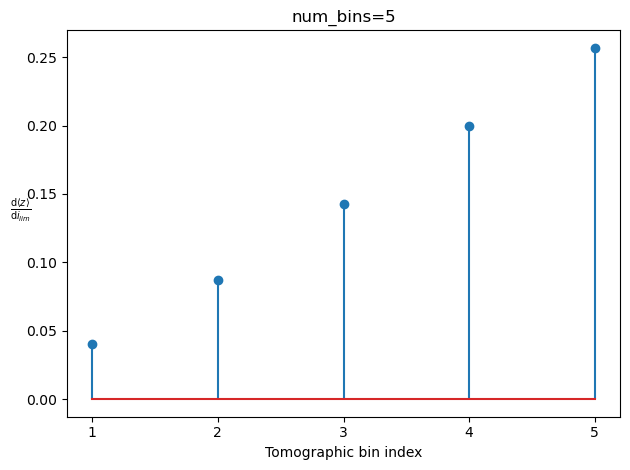

In [17]:
num_bins = 5
_ = plt.stem(range(1,1+num_bins), sensitivity(num_bins, fiducial_ilim=24.1))
_ = plt.ylabel(r"$\frac{\mathrm{d}\langle z \rangle}{\mathrm{d}i_{lim}}$", rotation=0)
_ = plt.xlabel("Tomographic bin index")
_ = plt.xticks(range(1,1+num_bins))
_ = plt.title(f"{num_bins=}")
plt.tight_layout()

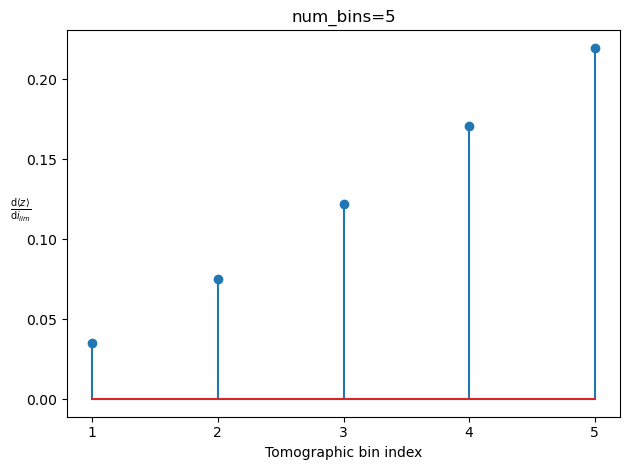

In [18]:
num_bins = 5
_ = plt.stem(range(1,1+num_bins), sensitivity(num_bins, fiducial_ilim=25.3))
_ = plt.ylabel(r"$\frac{\mathrm{d}\langle z \rangle}{\mathrm{d}i_{lim}}$", rotation=0)
_ = plt.xlabel("Tomographic bin index")
_ = plt.xticks(range(1,1+num_bins))
_ = plt.title(f"{num_bins=}")
plt.tight_layout()

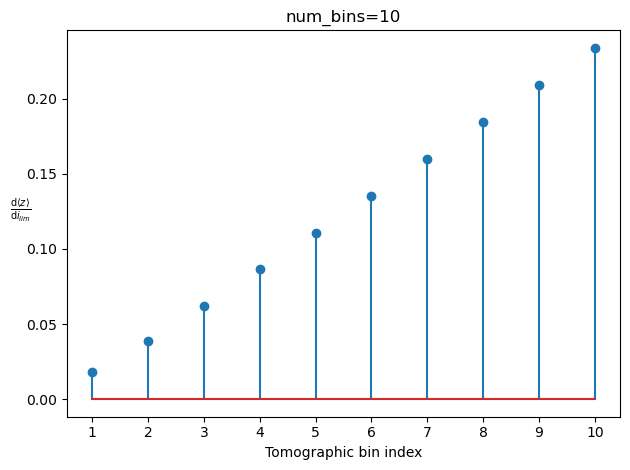

In [19]:
num_bins = 10
_ = plt.stem(range(1,1+num_bins), sensitivity(num_bins, fiducial_ilim=25.3))
_ = plt.ylabel(r"$\frac{\mathrm{d}\langle z \rangle}{\mathrm{d}i_{lim}}$", rotation=0)
_ = plt.xlabel("Tomographic bin index")
_ = plt.xticks(range(1,1+num_bins))
_ = plt.title(f"{num_bins=}")
plt.tight_layout()